# `regions_to_network`

The `regions_to_network` function is part of the `snow2` network extraction process.  This function analyzes an image of labeled regions, such as that produced by a watershed segmentation, and extracts topological connections and geometric properties.  The inner workings of this function are described by [Gostick](https://doi.org/10.1103/PhysRevE.96.023307).  To summarize, the function analyzes one region at a time, dilates that regions to see what other regions it is neighbors with to establish topology, then analyzes the distance transform within that region to determine geometric properties. 

In [1]:
import porespy as ps
import matplotlib.pyplot as plt
import numpy as np
from edt import edt

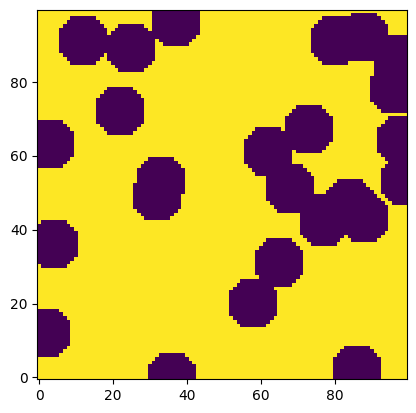

In [5]:
np.random.seed(13)
im = ps.generators.overlapping_spheres([100, 100], r=7, porosity=0.7)
plt.imshow(im, origin='lower', interpolation='none');

In [7]:
print(ps.networks.regions_to_network.__doc__)


    Analyzes an image that has been partitioned into pore regions and extracts
    the pore and throat geometry as well as network connectivity.

    Parameters
    ----------
    regions : ndarray
        An image of the material partitioned into individual regions.
        Zeros in this image are ignored.
    phases : ndarray, optional
        An image indicating to which phase each voxel belongs. The returned
        network contains a 'pore.phase' array with the corresponding value.
        If not given a value of 1 is assigned to every pore.
    voxel_size : scalar (default = 1)
        The resolution of the image, expressed as the length of one side of a
        voxel, so the volume of a voxel would be **voxel_size**-cubed.
    accuracy : string
        Controls how accurately certain properties are calculated. Options are:

        'standard' (default)
            Computes the surface areas and perimeters by simply counting
            voxels.  This is *much* faster but does no

## `regions`

This is the watershed segmentation of the image, presumably computed by `ps.filters.snow_partitioning` but could actually be any watershed image.

0it [00:00, ?it/s]

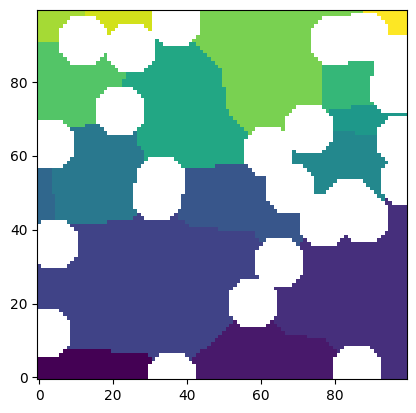

In [11]:
snow = ps.filters.snow_partitioning(im)
plt.imshow(snow.regions/im, origin='lower', interpolation='none');

In [23]:
net1 = ps.networks.regions_to_network(regions=snow.regions)

Extracting pore and throat properties:   0%|          | 0/16 [00:00<?, ?it/s]

The `regions_to_network` functions returns `dict` containing all the network information in OpenPNM format:

In [24]:
for item in net1.keys():
    print(item)

throat.conns
pore.coords
pore.all
throat.all
pore.region_label
pore.phase
throat.phases
pore.region_volume
pore.equivalent_diameter
pore.local_peak
pore.global_peak
pore.geometric_centroid
throat.global_peak
pore.inscribed_diameter
pore.extended_diameter
throat.inscribed_diameter
throat.total_length
throat.direct_length
throat.perimeter
pore.volume
pore.surface_area
throat.cross_sectional_area
throat.equivalent_diameter


## `phases`

Optionally it is possible to perform a multiphase extraction, by passing an image with each phase labelled as follows:

0it [00:00, ?it/s]

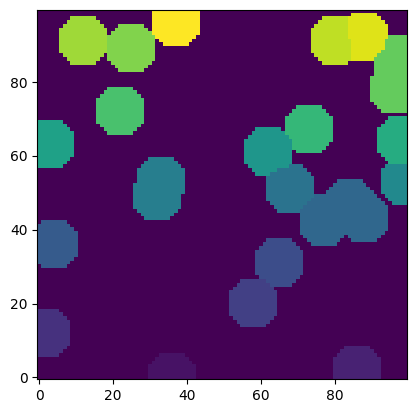

In [25]:
snow2 = ps.filters.snow_partitioning(~im)
plt.imshow(snow2.regions, origin='lower', interpolation='none');

We can manually combine these two watersheds:

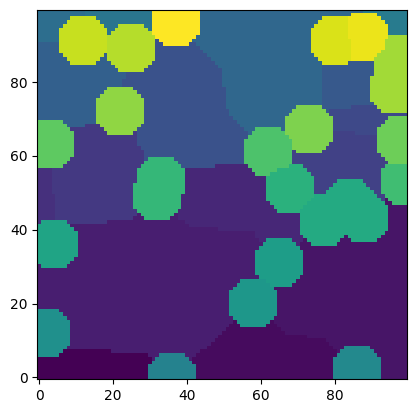

In [26]:
ws = snow.regions + (snow2.regions + snow.regions.max())*~im
plt.imshow(ws, origin='lower', interpolation='none');

Now we can send this combined watershed image, along with an image with each phase labelled as 1 and 2 to `regions_to_network`:

In [28]:
net2 = ps.networks.regions_to_network(regions=ws, phases=im.astype(int)+1)

Extracting pore and throat properties:   0%|          | 0/37 [00:00<?, ?it/s]

In [29]:
for item in net2.keys():
    print(item)

throat.conns
pore.coords
pore.all
throat.all
pore.region_label
pore.phase
throat.phases
pore.region_volume
pore.equivalent_diameter
pore.local_peak
pore.global_peak
pore.geometric_centroid
throat.global_peak
pore.inscribed_diameter
pore.extended_diameter
throat.inscribed_diameter
throat.total_length
throat.direct_length
throat.perimeter
pore.volume
pore.surface_area
throat.cross_sectional_area
throat.equivalent_diameter


Both `net1` and `net2` have `'pore.phase'` and `'throat.phases'`, but the difference is that in `net1` the values are all 1 since only a single phase was presents, while in `net2` these arrays contain boths 1's and 2's:

In [30]:
net1['pore.phase']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [31]:
net2['pore.phase']

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

These two arrays are used by the `label_phases` function, which takes that information and creates actual labels that can be used in OpenPNM.

## `voxel_size`
This is the voxel size of the image, as in the length of one side of a voxel.  Typical microtomography images are in the range of 1-5 um per voxel.  NanoCT can be as low as 16 nm per voxel.  FIB-SEM might be 4 nm per voxel.  Note that all properties returned from the ``snow2`` function, like 'pore.volume' will be in the same units are this value. It is *strongly* recommended to use SI, which is assumed in OpenPNM for most of the fluid property calculations. 

## `accuracy`

This argument can either take the value of `'high'` or `'standard'`, with standard being the default.  It is not recommended to use `'high'` since this uses some rather slow functions to measure the surface areas and perimeters.  The increase in accuracy is basically futile since (a) the image has already been reduced to a coarse voxelization and (b) the pore network abstraction discards information about the actual microstructure in exchange for speed, so spending ages on the extraction step would undermine this purpose. 